# Advanced Tutorial
In this advanced example we illustrate how to generate a synthetic data set using manually created ``Observation``, ``Instrument`` and ``Scene`` objects. We simulate the observation of an Eart-twin around a Suntwin at 10 pc with the LIFE baseline design.

## Import the Required Modules


In [ ]:
import astropy.units as u
import matplotlib.pyplot as plt

from phringe.entities.observation import Observation
from phringe.entities.perturbations.amplitude_perturbation import AmplitudePerturbation
from phringe.entities.perturbations.phase_perturbation import PhasePerturbation
from phringe.entities.perturbations.polarization_perturbation import PolarizationPerturbation
from phringe.entities.scene import Scene
from phringe.entities.sources.exozodi import Exozodi
from phringe.entities.sources.local_zodi import LocalZodi
from phringe.entities.sources.planet import Planet
from phringe.entities.sources.star import Star
from phringe.main import PHRINGE
from phringe.util.library import LIFEBaselineArchitecture

## Create the Main PHRINGE Object

`PHRINGE` will run on CPU if `gpu=None`. To run int on GPU, an index specifying the GPU is required, e.g. `gpu=0`. For reproducibility `seed` can be set to a specific value, resulting in identical results for each run. Note that `seed=None` results in the use of a random seed each run.

In [18]:
phringe = PHRINGE(gpu_index=1, seed=None, grid_size=40)

## Create an Observation and Set it

Arguments that require numerical values with units can be passed either as 
1. astropy quantities, e.g. `10 * u.m`
2. strings with units, e.g. `'10 m'`, or
3. floats (ints), assuming SI units, e.g. `10`.

The use of astropy quantities is recommended for clarity.

In [19]:
obs = Observation(
    solar_ecliptic_latitude=0 * u.deg,  # alternatively: '0 deg' or 0
    total_integration_time=1 * u.day,  # alternatively: '1 d' or 86400
    detector_integration_time=600 * u.s,  # alternatively: '600 s' or 600
    modulation_period=1 * u.day,  # alternatively: '1 d' or 86400
    optimized_differential_output=0,  # This is used to calculate the nulling baseline length
    optimized_star_separation='habitable-zone',  # This is used to calculate the nulling baseline length
    optimized_wavelength=10 * u.um
    # alternatively: '10 um' or 1e-5; this is used to calculate the nulling baseline length
)
phringe.set(obs)

**Note:** After initialization, the class attributes are converted to SI units and stored as floats, as astropy quantiteis can have a significant impact on performance. For instance:

In [20]:
obs.total_integration_time

86400.0

## Create an Instrument and Set it
An instrument can be created manually using the `Instrument` class or by using a predefined instrument frmo the library. Here, we use the predefined LIFE baseline architecture as our instrument.   

In [21]:
inst = LIFEBaselineArchitecture()
phringe.set(inst)

**Note:** Attributes of objects can also be updated. For instance, changing the aperture diameter from the predefined value to 3.5 m:

In [22]:
print(f'Predefined aperture diameter: {inst.aperture_diameter}')

inst.aperture_diameter = 3.5  # Attributes are stored as floats (see above), so we input floats in SI units

print(f'Updated aperture diameter: {inst.aperture_diameter}')

Predefined aperture diameter: 2.0
Updated aperture diameter: 3.5


For the instrument we have defined we can now e.g. check the resulting wavelength bins. This depends on its minimum and maximum wavelengths and spectral resolving power:

In [23]:
phringe.get_wavelength_bin_centers()

tensor([4.1026e-06, 4.3130e-06, 4.5341e-06, 4.7666e-06, 5.0111e-06, 5.2681e-06,
        5.5382e-06, 5.8222e-06, 6.1208e-06, 6.4347e-06, 6.7647e-06, 7.1116e-06,
        7.4763e-06, 7.8597e-06, 8.2628e-06, 8.6865e-06, 9.1319e-06, 9.6003e-06,
        1.0093e-05, 1.0610e-05, 1.1154e-05, 1.1726e-05, 1.2328e-05, 1.2960e-05,
        1.3624e-05, 1.4323e-05, 1.5058e-05, 1.5830e-05, 1.6642e-05, 1.7495e-05,
        1.8216e-05])

Once we have set both an observation and an instrument, we can also calculate the resulting nulling baseline length:

In [24]:
phringe.get_nulling_baseline()

AttributeError: 'NoneType' object has no attribute 'star'

## Create a Scene and Set it
The `Scene` object defined the astrophysical scene that is observed by the instrument. We first create an empty scene and then add sources to it later.

In [25]:
scene = Scene()
phringe.set(scene)

We now add sources corresponding to a star with an exozodiacal disk (exozodi) orbited by a planet as seen through the local zodiacal dust (local zodi).

In [26]:
sun_twin = Star(
    name='Sun-Twin',
    distance=10 * u.pc,
    mass=1 * u.Msun,
    radius=1 * u.Rsun,
    temperature=5778 * u.K,
    right_ascension=10 * u.hourangle,  # Uses units of degrees, not time
    declination=45 * u.deg,
)
earth_twin = Planet(
    name='Earth-Twin',
    has_orbital_motion=False,  # Whether the planet is propagated in time along its orbit
    mass=1 * u.Mearth,
    radius=1 * u.Rearth,
    temperature=254 * u.K,
    semi_major_axis=1 * u.au,
    eccentricity=0,
    inclination=0 * u.deg,
    raan=0 * u.deg,
    argument_of_periapsis=135 * u.deg,
    true_anomaly=0 * u.deg,
    path_to_spectrum=None,
    host_star_distance=10 * u.pc,  # Is only required if not star is added explicitly to the scene
    host_star_mass=1 * u.Msun,  # Is only required if not star is added explicitly to the scene
)
exozodi = Exozodi(
    level=3.0,  # 3 times the local zodiacal dust level
    host_star_luminosity=1 * u.Lsun,  # Is only required if not star is added explicitly to the scene
    host_star_distance=10 * u.pc,  # Is only required if not star is added explicitly to the scene
)
local_zodi = LocalZodi(
    host_star_right_ascension=10 * u.hourangle,  # Is only required if not star is added explicitly to the scene
    host_star_declination=45 * u.deg,  # Is only required if not star is added explicitly to the scene
)

scene.add_source(sun_twin)
scene.add_source(earth_twin)
scene.add_source(exozodi)
scene.add_source(local_zodi)

We can now also have a look at the spectra that have been generated for the sources:

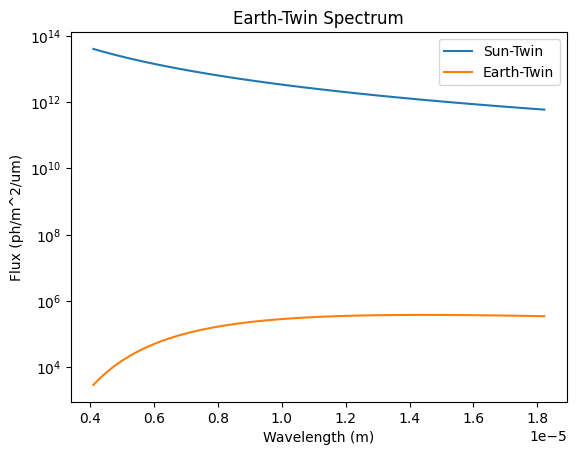

In [27]:
sun_twin_spectrum = phringe.get_source_spectrum('Sun-Twin').cpu().numpy()
earth_twin_spectrum = phringe.get_source_spectrum('Earth-Twin').cpu().numpy()
wavelengths = phringe.get_wavelength_bin_centers().cpu().numpy()

plt.plot(wavelengths, sun_twin_spectrum, label='Sun-Twin')
plt.plot(wavelengths, earth_twin_spectrum, label='Earth-Twin')
plt.title('Earth-Twin Spectrum')
plt.ylabel('Flux (ph/m^2/um)')
plt.xlabel('Wavelength (m)')
plt.yscale('log')
plt.legend()
plt.show()

## Add Instrument Perturbations
A key functionality of `PHRINGE` is the simulation of instrumental perturbations. As is, instrument are created without perturbations and assumed to be perfect. We now add perturbations in amplitude, phase and polarization to our instrument. 

In [28]:
ampl = AmplitudePerturbation(rms=0.1 * u.percent, color='pink')
phase = PhasePerturbation(rms=1.5 * u.nm, color='pink')
pol = PolarizationPerturbation(rms=0.001 * u.rad, color='pink')

inst.add_perturbation(ampl)
inst.add_perturbation(phase)
inst.add_perturbation(pol)

## Calculate the Counts on the Detector
We calculate the raw counts at all four outputs of the nulling interferometer and use it to calculate the differential counts (on a CPU this is likely going to take a few tens of seconds).

In [29]:
counts = phringe.get_counts()
diff_counts = counts[2] - counts[3]  # Alternatively: phringe.get_diff_counts()

100%|██████████| 1/1 [00:12<00:00, 12.79s/it]


## Plot the Differential Counts
Then we can plot the differential counts:

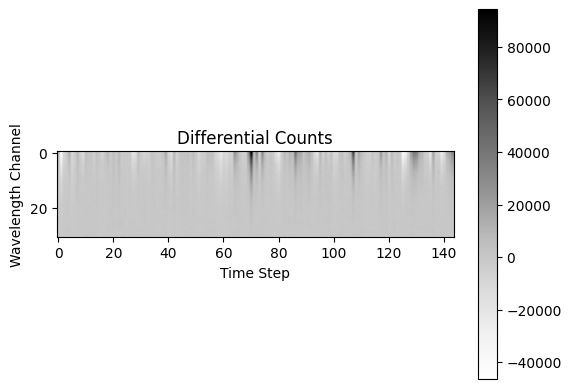

In [30]:
plt.imshow(diff_counts.cpu().numpy(), cmap='Greys')
plt.title('Differential Counts')
plt.ylabel('Wavelength Channel')
plt.xlabel('Time Step')
plt.colorbar()
plt.show()